The following code pre-process reviews from the Google Play store to then build a bayes model to estimate positive reviews from users and compare its performance with other bayes models as well as other classification models 

# All imports

In [13]:
import pandas as pd
import string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pickle import dump, load
from sklearn.feature_selection import chi2 , SelectKBest, mutual_info_regression
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score, make_scorer, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn import tree


# Importing data

In [14]:
url='https://raw.githubusercontent.com/4GeeksAcademy/naive-bayes-project-tutorial/main/playstore_reviews.csv'
rev_raw=pd.read_csv(url)

# Exploring data

In [15]:
rev_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   package_name  891 non-null    object
 1   review        891 non-null    object
 2   polarity      891 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.0+ KB


Deleting variable package name as it does not add relevant data to the sentiment analysis

In [16]:
rev_raw.drop('package_name', axis=1, inplace=True)

In [17]:
rev_raw.head()

,review,polarity
0,privacy at least put some option appear offli...,0
1,"messenger issues ever since the last update, ...",0
2,profile any time my wife or anybody has more ...,0
3,the new features suck for those of us who don...,0
4,forced reload on uploading pic on replying co...,0


# Data pre-processing

## Removing/replacing carachters not needed

In [18]:
#Setting all letters lowercase 
#Removing numbers and replacing them with a space
rev_raw['review']=rev_raw['review'].str.lower().str.replace('\d', ' ')

#Replacing ' with an space
rev_raw['review']=rev_raw['review'].str.lower().str.replace('\'', ' ')

#Removing special carachters: !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~
rev_raw['review']=rev_raw['review'].str.lower().str.translate(str.maketrans("", "", string.punctuation))

## Removing stop words

In [19]:
import nltk #pip install nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

rev_raw['review']=rev_raw['review'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))


[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Confirming removal/replacing went well

In [20]:
#pd.set_option('display.max_rows', None)
rev_raw.head()

,review,polarity
0,privacy least put option appear offline mean p...,0
1,messenger issues ever since last update initia...,0
2,profile time wife anybody one post view would ...,0
3,new features suck us working back button guys ...,0
4,forced reload uploading pic replying comment l...,0


## Splitting data into train and test

In [21]:
X = rev_raw["review"]
y = rev_raw["polarity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.head()

331    latest update viber yet update problemsi send ...
733    keeps crashing works well extreme data savings...
382    fail boat arrived 60 version touted advanced f...
704    superfast remember opera mini 1 browser back d...
813    installed immediately deleted crap used firefo...
Name: review, dtype: object

## Transforming text into word count

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

vector_m = CountVectorizer(stop_words = "english")
X_train_c = vector_m.fit_transform(X_train).toarray()
X_test_c = vector_m.transform(X_test).toarray()

## Transforming text into binary matrix

This data will be used for the bernoulli model as it works with binary data

In [23]:
vector_b = CountVectorizer(stop_words = "english", binary=True)
X_train_b = vector_m.fit_transform(X_train).toarray()
X_test_b = vector_m.transform(X_test).toarray()

# Model estimation

## Estimating bayes model - multinomial

In [24]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_c, y_train)

MultinomialNB()

In [25]:
y_pred = model.predict(X_test_c)

In [26]:
mul_acc=accuracy_score(y_test, y_pred)

## Estimating bayes - Gaussian

In [27]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

model_g = GaussianNB()
model_g.fit(X_train_c, y_train)

y_pred_g=model_g.predict(X_test_c)
gauss_acc=accuracy_score(y_test, y_pred_g)


## Estimating bayes - Bernoulli

In [28]:
model_b = BernoulliNB()
model_b.fit(X_train_b, y_train)

y_pred_b=model_b.predict(X_test_b)

bern_acc=accuracy_score(y_test, y_pred_b)

## Comparing accuracy across bayes models:

So far, the Gaussian model seems to have the best accuracy on predicting positive reviews'sentiment 

In [29]:
print('Multinomial baseline accuracy: ', mul_acc )                       
print('Gaussian baseline accuracy: ', gauss_acc )
print('Bernoulli baseline accuracy: ', bern_acc)

Multinomial baseline accuracy:  0.8044692737430168
Gaussian baseline accuracy:  0.8100558659217877
Bernoulli baseline accuracy:  0.7597765363128491


## Hyperparameter optimisation

The optimisation will be performed on the multinomial model. Although the Gaussian model showed the best baseline accuracy across all bayes models used, it works best with continous data and the current data is discrete

In [30]:
hyprms= {    "alpha": np.linspace(0.01, 50, 200),
    "fit_prior": [True, False]
}

model_opt = RandomizedSearchCV(model, hyprms, n_iter = 400, scoring = "accuracy", cv = 5, random_state = 42)


In [31]:
model_opt.fit(X_train_c, y_train)

RandomizedSearchCV(cv=5, estimator=MultinomialNB(), n_iter=400,
                   param_distributions={'alpha': array([1.00000000e-02, 2.61206030e-01, 5.12412060e-01, 7.63618090e-01,
       1.01482412e+00, 1.26603015e+00, 1.51723618e+00, 1.76844221e+00,
       2.01964824e+00, 2.27085427e+00, 2.52206030e+00, 2.77326633e+00,
       3.02447236e+00, 3.27567839e+00, 3.52688442e+00, 3.77809045e+00,
       4.02929648e+0...
       4.52270854e+01, 4.54782915e+01, 4.57294975e+01, 4.59807035e+01,
       4.62319095e+01, 4.64831156e+01, 4.67343216e+01, 4.69855276e+01,
       4.72367337e+01, 4.74879397e+01, 4.77391457e+01, 4.79903518e+01,
       4.82415578e+01, 4.84927638e+01, 4.87439698e+01, 4.89951759e+01,
       4.92463819e+01, 4.94975879e+01, 4.97487940e+01, 5.00000000e+01]),
                                        'fit_prior': [True, False]},
                   random_state=42, scoring='accuracy')

In [32]:
#Storing Grid search results as dataframe
result=pd.DataFrame(model_opt.cv_results_)

There is a negative association between accuracy and alpha for alpha values greater than 10. For alpha values less than 10, the association is possitive until it reaches a maximum value (alpha~=9), then, it declines

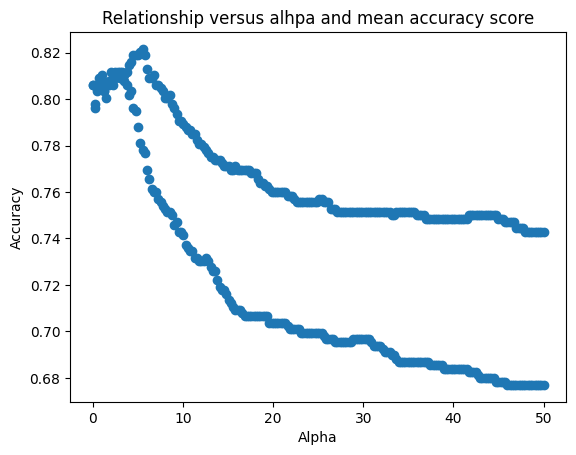

In [33]:
plt.scatter(result['param_alpha'], result['mean_test_score'])
plt.title('Relationship versus alhpa and mean accuracy score')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.show()

Storing best hparameters

In [34]:
best_params=model_opt.best_params_
best_params
dump(model, open("/workspaces/naive_bayes/models/multinom_alpha_5.5_fit_prior_False_42.sav", "wb"))

Re-estimating optimised model:

In [35]:
model_opt=MultinomialNB(**best_params)
model_opt.fit(X_train_c, y_train)


MultinomialNB(alpha=5.536532663316582, fit_prior=False)

In [36]:
y_pred_opt=model_opt.predict(X_test_c)
mul_opt_acc=accuracy_score(y_test, y_pred_opt)

The optimised multinomial model increased its accuracy, compared to the baseline model by roughly 3 percentage points

In [37]:
print('Multinomial baseline accuracy: ', mul_acc)                       
print('Multinomial optimised accuracy: ', mul_opt_acc)    

Multinomial baseline accuracy:  0.8044692737430168
Multinomial optimised accuracy:  0.8268156424581006


# Exploring other models

Potential models that could fit the data and why they may or may not work well: 

*   **Logistic regression:** could be an option but these models struggle to converge when the covariates are 'flat', meaning that covariates are binary or have little variation. This data is 'flat' since a lot of the variables (e.g., words) may have zeros in them. 

* **Decision tree:** it is a good option since here the scale of the variables is not that important as in the case of regresssion. However, since the dataset is small, it would benefit more from using random forest as it can provide a more robust result.

* **Boosting:** Another good alternative that would suit the data well, but this model is more computationally demanding and it works better with bigger datasets

Conclusion: random forests is a good alternative to test 

Baseline random forest:

In [38]:
rf_base=RandomForestClassifier(random_state=42)
rf_base.fit(X_train_c, y_train)

RandomForestClassifier(random_state=42)

In [39]:
y_pred_rf=rf_base.predict(X_test_c)
rf_acc=accuracy_score(y_test, y_pred_rf)

## Comparing bayes multinomial versus random forest

The trained random forest baseline model produced the same accuracy score as the one obtained with the baseline score of the multinomial model. This result is possible given that both models are just baseline, and therefore, they use the default hyperparameters

In [40]:
print('Random forest baseline accuracy: ', rf_acc)  
print('Multinomial baseline accuracy: ', mul_acc)                       
print('Multinomial optimised accuracy: ', mul_opt_acc)  

Random forest baseline accuracy:  0.8044692737430168
Multinomial baseline accuracy:  0.8044692737430168
Multinomial optimised accuracy:  0.8268156424581006
